In [49]:
import torch
import numpy as np
import copy
import matplotlib.pyplot as plt
import os
import pickle

from copy import deepcopy

from torch.utils.data import Dataset

from tqdm import tqdm

from utilities import *

from torch_tiny_imagenet.NaiveResNet import *
from torch_tiny_imagenet.utils import show_images_horizontally

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [51]:
class ResNetEncoder(nn.Module):
    
    def __init__(self, feature_dim=256, num_blocks=2, normalize=True):
        
        super(ResNetEncoder, self).__init__()
        
        self.resnet = NaiveResNet(num_classes=feature_dim, num_blocks=num_blocks)
        self.normalize = normalize
        
    def forward(self, x):
        
        z = self.resnet(x)
        if self.normalize:
            z = self.norm(z)
        return z
    
    def norm(self,z):
        
        return torch.nn.functional.normalize(z,dim=1)

In [52]:
class BilinearFDVNCE(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearFDVNCE,self).__init__()
        self.critic = critic
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, x, y, y0=None, K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
#         if K is None:
#             K = self.K 
#         g = self.critic(x, y)
#         g0 = self.critic(x, y0)
#         u  = self.u_func(x, y)
#         output = u + torch.exp(-u+g0-g) - 1
        output  = self.PMI(x,y)
#         output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K   
    
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        gxy = self.critic(x,y)
        if isinstance(gxy, tuple):
            hx,hy = gxy
            similarity_matrix = hx @ hy.t()
            
            pos_mask = torch.eye(hx.size(0),dtype=torch.bool)
            g = similarity_matrix[pos_mask].view(hx.size(0),-1)
            g0 = similarity_matrix[~pos_mask].view(hx.size(0),-1)
            
            logits = g0 - g
            
            slogits = torch.logsumexp(logits,1).view(-1,1)
            
            labels = torch.tensor(range(hx.size(0)),dtype=torch.int64).to(device)
            dummy_ce = self.criterion(similarity_matrix,labels) - torch.log(torch.Tensor([hx.size(0)]).to(device))
            dummy_ce = dummy_ce.view(-1,1)
            
            output = dummy_ce.detach()+torch.exp(slogits-slogits.detach())-1
            
        
#             g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
            
#             output = u + torch.exp(-u+g0_logsumexp-g)/(hx.size(0)-1) - 1
                


        else:      
            output = None
#                 g = gxy
#                 if K is not None:

#                     for k in range(K-1):

#                         if k==0:
#                             y0 = y0
#                             g0,_ = torch.chunk(self.critic(x,y0),2,dim=1)
#                         else:
#                             y0 = y[torch.randperm(y.size()[0])]
#                             g00,_ = torch.chunk(self.critic(x,y0),2,dim=1)
#                             g0 = torch.cat((g0,g00),1)

#                     g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
#                     output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
#                 else:    

#                     g0, _ = torch.chunk(self.critic(x,y0),2,dim=1)
#                     output = u + torch.exp(-u+g0-g) - 1
        return output

In [53]:
class BilinearNWJNCE(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearNWJNCE, self).__init__()
        self.critic = critic
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, x, y, y0=None, K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''

        output  = self.PMI(x,y)
#         output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K   
    
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        gxy = self.critic(x,y)
        if isinstance(gxy, tuple):
            hx,hy = gxy
            similarity_matrix = hx @ hy.t()
            
            pos_mask = torch.eye(hx.size(0),dtype=torch.bool)
            g = similarity_matrix[pos_mask].view(hx.size(0),-1)
            g0 = similarity_matrix[~pos_mask].view(hx.size(0),-1)
            
            output = torch.exp(torch.logsumexp(g0,1).view(-1,1)-1.)/torch.Tensor([hx.size(0)]).to(device)-g.view(-1,1)


        else:      
            output = None
                 
        return output

In [54]:
class BilinearCritic(nn.Module):
    
    '''
    encoder_x : dx -> feature_dim
    encoder_y : dy -> feature_dim
    u_func : 2*feature_dim -> 1
    
    version-1: Jun 3, 2021
      * Made encoder_y optional, for SSL settings multiple-views share the same encoder
    '''
    
    def __init__(self,
                 encoder_x: nn.Module,
                 encoder_y: Optional[nn.Module] = None,
                 u_func: Optional[nn.Module] = None,
                 tau: Optional[float] = 1.):
        
        super(BilinearCritic,self).__init__()
        self.encoder_x = encoder_x
        self.encoder_y = encoder_y
        self.u_func = u_func
        self.log_tau = torch.nn.Parameter(torch.Tensor([np.log(tau)]))
        
    
    def forward(self, x, y, tau=None):
        if tau is None:
            tau = torch.exp(self.log_tau)
        tau = torch.sqrt(tau)
        
        encoder_x = self.encoder_x
        encoder_y = self.encoder_y
        if encoder_y is None:
            encoder_y = encoder_x
            
        hx = self.norm(encoder_x(x))
        hy = self.norm(encoder_y(y))
        if self.u_func is not None:
            u = self.u_func(hx,hy)
            return hx/tau, hy/tau, u  
        
        return hx/tau, hy/tau  
    
    def norm(self,z):
        return torch.nn.functional.normalize(z,dim=1)

In [55]:
class BilinearInfoNCE(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearInfoNCE,self).__init__()
        self.critic = critic
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, x, y, y0=None, K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
#         if K is None:
#             K = self.K 
#         g = self.critic(x, y)
#         g0 = self.critic(x, y0)
#         u  = self.u_func(x, y)
#         output = u + torch.exp(-u+g0-g) - 1
        output  = self.PMI(x,y)
        output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K   
    
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        gxy = self.critic(x,y)
        if isinstance(gxy, tuple):
            hx,hy = gxy
            similarity_matrix = hx @ hy.t()
            labels = torch.tensor(range(hx.size(0)),dtype=torch.int64).to(device)
            output = self.criterion(similarity_matrix,labels) - torch.log(torch.Tensor([hx.size(0)]).to(device))

        else:      
            output = None
#                 g = gxy
#                 if K is not None:

#                     for k in range(K-1):

#                         if k==0:
#                             y0 = y0
#                             g0,_ = torch.chunk(self.critic(x,y0),2,dim=1)
#                         else:
#                             y0 = y[torch.randperm(y.size()[0])]
#                             g00,_ = torch.chunk(self.critic(x,y0),2,dim=1)
#                             g0 = torch.cat((g0,g00),1)

#                     g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
#                     output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
#                 else:    

#                     g0, _ = torch.chunk(self.critic(x,y0),2,dim=1)
#                     output = u + torch.exp(-u+g0-g) - 1
        return output

In [56]:
class BilinearTUBANCE(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         u_func: Optional[nn.Module] = None,
         K: Optional[int] = None,
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearTUBANCE,self).__init__()
        self.critic = critic
        self.u_func = u_func
        self.K = K
    def forward(self, x, y, y0,K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        if K is None:
            K = self.K 
#         g = self.critic(x, y)
#         g0 = self.critic(x, y0)
#         u  = self.u_func(x, y)
#         output = u + torch.exp(-u+g0-g) - 1
        output  = self.PMI(x,y,y0,K)
        output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K      
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''

        if self.u_func is not None:
            # two func mode
            u  = self.u_func(x)
            if K is not None:
            
                for k in range(K-1):

                    if k==0:
                        y0 = y0
                        g0 = self.critic(x, y0)
                    else:
                        y0 = y[torch.randperm(y.size()[0])]
                        g0 = torch.cat((g0,self.critic(x, y0)),1)

                g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
            else:               
                
                g = self.critic(x, y)
                g0 = self.critic(x, y0)
               
                output = u + torch.exp(-u+g0-g) - 1
        else:
            # one func mode
            gu = self.critic(x,y)
            if isinstance(gu, tuple):
                hx,hy,u = gu
                similarity_matrix = hx @ hy.t()
                pos_mask = torch.eye(hx.size(0),dtype=torch.bool)
                g = similarity_matrix[pos_mask].view(hx.size(0),-1)
                g0 = similarity_matrix[~pos_mask].view(hx.size(0),-1)
                g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                output = u + torch.exp(-u+g0_logsumexp-g)/(hx.size(0)-1) - 1

            else:      
                g, u = torch.chunk(self.critic(x,y),2,dim=1)
                if K is not None:

                    for k in range(K-1):

                        if k==0:
                            y0 = y0
                            g0,_ = torch.chunk(self.critic(x,y0),2,dim=1)
                        else:
                            y0 = y[torch.randperm(y.size()[0])]
                            g00,_ = torch.chunk(self.critic(x,y0),2,dim=1)
                            g0 = torch.cat((g0,g00),1)

                    g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                    output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
                else:    

                    g0, _ = torch.chunk(self.critic(x,y0),2,dim=1)
                    output = u + torch.exp(-u+g0-g) - 1
        return output
    
class TUBABilinearCritic(nn.Module):
    
    '''
    encoder_x : dx -> feature_dim
    encoder_y : dy -> feature_dim
    u_func : 2*feature_dim -> 1
    '''
    
    def __init__(self,
                 encoder_x: nn.Module,
                 encoder_y: nn.Module,
                 u_func: nn.Module,
                 tau: Optional[float] = 1.):
        
        super(TUBABilinearCritic,self).__init__()
        self.encoder_x = encoder_x
        self.encoder_y = encoder_y
        self.u_func = u_func
        self.log_tau = torch.nn.Parameter(torch.log(torch.Tensor([tau])))
        
    
    def forward(self, x, y, tau=None):
        if tau is None:
            tau = torch.exp(self.log_tau)
        tau = torch.sqrt(tau)
        hx = self.norm(self.encoder_x(x))
        hy = self.norm(self.encoder_y(y))
        u = self.u_func(hx)
        
        return hx/tau, hy/tau, u  
    
    def norm(self,z):
        return torch.nn.functional.normalize(z,dim=1)

In [57]:
class BilinearFenchelInfoNCEOne(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         u_func: Optional[nn.Module] = None,
         K: Optional[int] = None,
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearFenchelInfoNCEOne,self).__init__()
        self.critic = critic
        self.u_func = u_func
        self.K = K
    def forward(self, x, y, y0=None,K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        if K is None:
            K = self.K 
#         g = self.critic(x, y)
#         g0 = self.critic(x, y0)
#         u  = self.u_func(x, y)
#         output = u + torch.exp(-u+g0-g) - 1
        output  = self.PMI(x,y,y0,K)
        output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K      
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''

        if self.u_func is not None:
            # two func mode
            u  = self.u_func(x, y)
            if K is not None:
            
                for k in range(K-1):

                    if k==0:
                        y0 = y0
                        g0 = self.critic(x, y0)
                    else:
                        y0 = y[torch.randperm(y.size()[0])]
                        g0 = torch.cat((g0,self.critic(x, y0)),1)

                g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
            else:               
                
                g = self.critic(x, y)
                g0 = self.critic(x, y0)
               
                output = u + torch.exp(-u+g0-g) - 1
        else:
            # one func mode
            gu = self.critic(x,y,None)
            if isinstance(gu, tuple):
                hx,hy,u = gu
                similarity_matrix = hx @ hy.t()
                pos_mask = torch.eye(hx.size(0),dtype=torch.bool)
                g = similarity_matrix[pos_mask].view(hx.size(0),-1)
                g0 = similarity_matrix[~pos_mask].view(hx.size(0),-1)
                g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                output = u + torch.exp(-u+g0_logsumexp-g)/(hx.size(0)-1) - 1

            else:      
                g, u = torch.chunk(self.critic(x,y),2,dim=1)
                if K is not None:

                    for k in range(K-1):

                        if k==0:
                            y0 = y0
                            g0,_ = torch.chunk(self.critic(x,y0),2,dim=1)
                        else:
                            y0 = y[torch.randperm(y.size()[0])]
                            g00,_ = torch.chunk(self.critic(x,y0),2,dim=1)
                            g0 = torch.cat((g0,g00),1)

                    g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                    output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
                else:    

                    g0, _ = torch.chunk(self.critic(x,y0),2,dim=1)
                    output = u + torch.exp(-u+g0-g) - 1
        return output
    
    
class BilinearCriticFenchelInfoNCEOne(nn.Module):
    
    '''
    encoder_x : dx -> feature_dim
    encoder_y : dy -> feature_dim
    u_func : 2*feature_dim -> 1
    '''
    
    def __init__(self,
                 encoder_x: nn.Module,
                 encoder_y: nn.Module,
                 u_func: nn.Module,
                 tau: Optional[float] = 1.):
        
        super(BilinearCriticFenchelInfoNCEOne,self).__init__()
        self.encoder_x = encoder_x
        self.encoder_y = encoder_y
        self.u_func = u_func
        self.log_tau = torch.nn.Parameter(torch.Tensor([np.log(tau)]))
        
    
    def forward(self, x, y, tau=None):
        if tau is None:
            tau = torch.exp(self.log_tau)
        tau = torch.sqrt(tau)
        hx = self.norm(self.encoder_x(x))
        hy = self.norm(self.encoder_y(y))
        u = self.u_func(hx,hy)
        
        return hx/tau, hy/tau, u  
    
    def norm(self,z):
        return torch.nn.functional.normalize(z,dim=1)
        #return z/torch.sqrt(torch.square(z).sum(1).view(-1,1))
        #return z

In [58]:
lam = 1

args = {}
# args['lr'] = 1e-4
# args['lr'] = 1e-3
args['lr'] = 1e-2
args['latent_dim'] = 100
args['num_epochs'] = 50
# args["input_dim"] = 2*p
args['batch_size']=50

feature_dim = 4096
# feature_dim = 128

# encoder = ResNetEncoder(feature_dim=feature_dim)
# critic = BilinearCritic(encoder)
# mi_model = BilinearFDVNCE(critic)

# mi_model = mi_model.to(device)

### Load ImageNet

In [59]:
class SimpleDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.image = x
        self.targets = y
        self.transform = transform

    def __getitem__(self, index):
        if self.transform is not None:
            image = self.transform(image[index])
        target = self.targets[index]
        return image, target

    def __len__(self):
        return len(self.targets)

In [60]:
# class ImgDataset(Dataset):
#     def __init__(self, x, y, transform=None):
#         self.paths = x
#         self.targets = y
#         self.transform = transform

#     def __getitem__(self, index):
#         img = Image.open(self.paths[index]).convert('RGB')
#         if self.transform is not None:
#             img = self.transform(img)
#         target = self.targets[index]
#         return img, target

#     def __len__(self):
#         return len(self.targets)
    
def load_data(data_path='.', device=device):
#     device = 'cuda'
    train_file_path = os.path.join(data_path,'tiny_imagenet','train_tiny_data.pkl')
    test_file_path = os.path.join(data_path,'tiny_imagenet','test_tiny_data.pkl')
    with open(train_file_path, 'rb') as f:
        X_train = pickle.load(f)
        y_train = pickle.load(f).float()
    with open(test_file_path, 'rb') as f:
        X_test = pickle.load(f)
        y_test = pickle.load(f).float()
    return X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

In [61]:
class NewContrastiveDataSet(Dataset):
    def __init__(self, X, Y, name, transforms, n_view = 2, batch_size = 128):
        self.X = X
        self.Y = Y
        self.n_view = n_view
        self.name = name
        self.X1 = None
        self.X2 = None
        self.idx = None
        self.Y1 = None
        self.batch_size = batch_size
        self.transforms = transforms
        self.refresh()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x1 = self.X1[idx]
        x2 = self.X2[idx]
        y1 = self.Y1[idx]
        
        return [x1,x2],y1

    def refresh(self):
        size = 64
        s = .5
        gaussian = False
        
        # transforms_batch = get_simclr_pipeline_newtransform(size, device, s, gaussian)
        transforms_batch = self.transforms
        transforms_individual = []

        idx = np.random.permutation(len(self.X))
        
        self.X1 = deepcopy(self.X)
        self.X2 = deepcopy(self.X)
        self.Y1 = deepcopy(self.Y)
        
        n = len(self.X)
        batch_size = self.batch_size

        for k,transform in enumerate(transforms_individual):
            idx = np.random.permutation(len(self.X))
            self.X1 = self.X1[idx]
            self.X2 = self.X2[idx]
            self.Y1 = self.Y1[idx]
            for i in range(n):
                self.X1[i] = transform(self.X1[i])
                self.X2[i] = transform(self.X2[i])
            
        for k,transform in enumerate(transforms_batch):
            idx = np.random.permutation(len(self.X))
            self.X1 = self.X1[idx]
            self.X2 = self.X2[idx]
            self.Y1 = self.Y1[idx]
            
            for j in range(int(np.ceil(float(n)/batch_size))):
                st = j*batch_size
                ed = min((j+1)*batch_size,n)
                
                x = self.X1[st:ed]
                x = transform(x)
                self.X1[st:ed] = x
                x = self.X2[st:ed]
                x = transform(x)
                self.X2[st:ed] = x
                
        return 

In [62]:
# data_path = os.path.join(os.environ['HOME'],'projects-rick','SimCLR','SimCLR-fast','datasets')

# X_train, y_train, X_test, y_test = load_data(data_path, device=device)

# # X_train.shape
# # X_test.shape
# # y_test
# n_train = int(0.8*len(X_train))

# idx = np.random.permutation(len(X_train))
# X_train = X_train[idx]
# y_train = y_train[idx]

# X_test = X_train[n_train:]
# y_test = y_train[n_train:]

# X_train = X_train[:n_train]
# y_train = y_train[:n_train]

# augmentations = [
#     transforms.RandomApply([transforms.RandomHorizontalFlip()],p=0.5),
#     transforms.RandomApply([transforms.RandomRotation(30)],p=0.9),
#     transforms.RandomApply([transforms.RandomResizedCrop(64,scale=(0.3,1.))],p=0.8),
#     ]

In [63]:
from torchvision import datasets

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

mnist_path = 'data'

# choose the training and test datasets
train_data = datasets.MNIST(root=mnist_path, train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root=mnist_path, train=False,
                                  download=True, transform=transform)

X_train = train_data.data.float()/255.
y_train = train_data.targets
X_test = test_data.data.float()/255.
y_test = test_data.targets

X_train = transforms.Resize(64)(X_train).unsqueeze(1)
X_test = transforms.Resize(64)(X_test).unsqueeze(1)

X_train = X_train[:40000]
y_train = y_train[:40000]

X_test = X_test[:10000]
y_test = y_test[:10000]

X_train = torch.cat([X_train,X_train,X_train],dim=1).to(device)
X_test = torch.cat([X_test,X_test,X_test],dim=1).to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

augmentations = [
#     transforms.RandomApply([transforms.RandomHorizontalFlip()],p=0.5),
    transforms.RandomApply([transforms.RandomRotation(30)],p=0.9),
    transforms.RandomApply([transforms.RandomResizedCrop(64,scale=(0.5,1.))],p=0.8),
    ]

In [80]:
train_dataset = NewContrastiveDataSet(X_train,y_train,'train',transforms=augmentations)
test_dataset = list(zip(X_test,y_test))
# # test_dataset = SimpleDataset(X_test, y_test)

In [65]:
args['batch_size'] = 512
# args['batch_size'] = 128
# args['batch_size'] = 8

In [66]:
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], drop_last=False, shuffle=False)

In [67]:
train_iter = iter(train_loader)
test_iter = iter(test_loader)

In [68]:
(x1,x2),y = next(train_iter)
x3,y = next(test_iter)

### Check augmentation

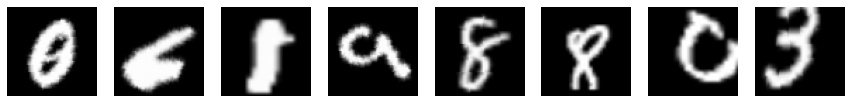

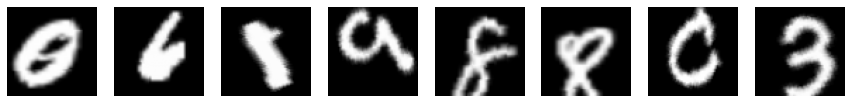

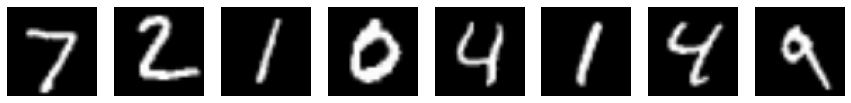

In [69]:
show_images_horizontally(x1[:8].cpu(), un_normalize=False)
show_images_horizontally(x2[:8].cpu(), un_normalize=False)
show_images_horizontally(x3[:8].cpu(), un_normalize=False)

### Load the model

In [70]:
mdl_name = 'flo'
save_dir = 'saved_models'

epoch_id = 50
save_path = os.path.join(save_dir,mdl_name)
# if os.path.isdir(save_path) is False:
#     os.mkdir(save_path)
mdl_file = os.path.join(save_path,'ep_'+str(epoch_id).zfill(4)+'.ckpt')
if os.path.isfile(mdl_file):
    mi_model = torch.load(mdl_file)
else:
    raise IOError('No. such file!')

# mi_model.eval()

# mi_model

encoder = mi_model.critic.encoder_x
encoder.eval()

ResNetEncoder(
  (resnet): NaiveResNet(
    (groups): ModuleList(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Sequential(
        (0): ResidualBlock(
          (conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU(inplace=True)
            (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (downsample): Sequential(
            (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
            (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        

In [71]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [72]:
n_classes = 200

In [73]:
predictor = MLP(feature_dim, n_classes, hidden_dim=[])

In [74]:
predictor = predictor.to(device)

In [75]:
optimizer = torch.optim.Adam(predictor.parameters(),lr=args['lr'])
# optimizer = torch.optim.Adam([*encoder.parameters(),*predictor.parameters()],lr=args['lr'])
# optimizer = torch.optim.SGD([*encoder.parameters(),*predictor.parameters()],lr=args['lr'])

In [76]:
# args['lr']

In [77]:
# args['ckpt_interval'] = 5
args['num_epochs'] = 100

In [78]:
tinyimg = []

# encoder.train()
encoder.eval()
predictor.train() # prep model for training

criterion = torch.nn.CrossEntropyLoss()

for epoch_counter in range(0, args['num_epochs']):
    
    epoch_id = epoch_counter+1
    
    # monitor training loss
    train_loss = 0.0
    train_mi = 0.0
    ###################
    # train the model #
    ###################
#     model.train()

    top1_accuracy = 0.
    top5_accuracy = 0.
    num_samples = 0
#     if epoch_counter>0:

    encoder.eval()
    predictor.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images, _ = images
        labels = labels.long()

        features = encoder(images)
        logits = predictor(features)


        top1, top5 = accuracy(logits, labels, topk=(1,5))
        top1_accuracy += top1[0]*images.size(0)
        top5_accuracy += top5[0]*images.size(0)
        num_samples += images.size(0)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        total_loss = criterion(logits,labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        total_loss.backward()
        optimizer.step()
        # perform a single optimization step (parameter update)


        # update running training loss
        # train_loss += loss.item()*data.size(0)
        train_loss += total_loss.item()*images.size(0)

    train_loader.dataset.refresh()
    
    predictor.eval()
    encoder.eval()
    
#     top1_accuracy = 0.
#     top5_accuracy = 0.
#     num_samples = 0
# #     for i, (images, labels) in enumerate(tqdm(test_loader)):
#     for i, (images, labels) in enumerate(tqdm(train_loader)):
#         images,_ = images
        
#         labels = labels.long()
        
#         features = encoder(images)
#         logits = predictor(features)
        
#         top1, top5 = accuracy(logits, labels, topk=(1,5))
#         top1_accuracy += top1[0]*images.size(0)
#         top5_accuracy += top5[0]*images.size(0)
#         num_samples += images.size(0)
        
#         if i>=20:
#             break
    
    top1_accuracy /= num_samples
    top5_accuracy /= num_samples
    
    top1_accuracy_train = top1_accuracy
    top5_accuracy_train = top5_accuracy
    
    top1_accuracy = 0.
    top5_accuracy = 0.
    num_samples = 0
    for i, (images, labels) in enumerate(tqdm(test_loader)):
        
        labels = labels.long()
        
        features = encoder(images)
        logits = predictor(features)
        
        top1, top5 = accuracy(logits, labels, topk=(1,5))
        top1_accuracy += top1[0]*images.size(0)
        top5_accuracy += top5[0]*images.size(0)
        num_samples += images.size(0)
    
    top1_accuracy /= num_samples
    top5_accuracy /= num_samples
    
    top1_accuracy_test = top1_accuracy
    top5_accuracy_test = top5_accuracy
    
    train_loss = train_loss/len(y_train)
    
    
#     print('Epoch: {}\t Loss: {:4f}, Top-1:{:4f}, Top-5:{:4f}'.format(epoch_counter+1, 
#                     train_loss,top1_accuracy,top5_accuracy))
    
    print('Epoch: {}\t Loss: {:4f}, Train: 1:{:4f}, 5:{:4f}, Test: 1:{:4f}, 5:{:4f} '.format(epoch_counter+1, 
                    train_loss,top1_accuracy_train,top5_accuracy_train,top1_accuracy_test,top5_accuracy_test))
    
        
#     print('Epoch: {}\t Loss: {:4f}, Top-1:{:4f}, Top-5:{:4f}'.format(epoch_counter+1, 
#                     train_loss,top1_accuracy,top5_accuracy))
    
#     tinyimg_top1.append(top1_accuracy)
    
    tinyimg.append([train_loss,top1_accuracy,top5_accuracy])
#     np.save('flo_tinyimg.npy', tinyimg)

# idx_max = np.argmax(tinyimg[:,1])
# print(f'Best accuracy at {idx_max}, Top-1: {tinyimg[idx_max,1]}, Top-5: {tinyimg[idx_max,2]}')
# print(max(top1_accuracy))

  3%|▎         | 2/78 [00:00<00:04, 16.42it/s]

Epoch: 1	 Loss: 1.699030, Train: 1:84.868294, 5:94.849258, Test: 1:91.699997, 5:98.820000 


  3%|▎         | 2/78 [00:00<00:04, 16.04it/s]

Epoch: 2	 Loss: 0.351727, Train: 1:92.921173, 5:99.168671, Test: 1:94.250000, 5:99.389999 


  3%|▎         | 2/78 [00:00<00:04, 15.98it/s]

Epoch: 3	 Loss: 0.245463, Train: 1:94.381012, 5:99.506714, Test: 1:94.979996, 5:99.529999 


  3%|▎         | 2/78 [00:00<00:04, 15.82it/s]

Epoch: 4	 Loss: 0.205402, Train: 1:95.012024, 5:99.631912, Test: 1:95.549995, 5:99.589996 


  3%|▎         | 2/78 [00:00<00:04, 16.49it/s]

Epoch: 5	 Loss: 0.187729, Train: 1:95.182289, 5:99.644432, Test: 1:95.799995, 5:99.639999 


  3%|▎         | 2/78 [00:00<00:04, 15.99it/s]

Epoch: 6	 Loss: 0.169761, Train: 1:95.597961, 5:99.722054, Test: 1:95.829994, 5:99.680000 


  3%|▎         | 2/78 [00:00<00:04, 16.55it/s]

Epoch: 7	 Loss: 0.164560, Train: 1:95.733177, 5:99.709534, Test: 1:96.019997, 5:99.689995 


  3%|▎         | 2/78 [00:00<00:04, 16.53it/s]

Epoch: 8	 Loss: 0.156755, Train: 1:95.863380, 5:99.729568, Test: 1:96.000000, 5:99.759995 


  3%|▎         | 2/78 [00:00<00:04, 16.39it/s]

Epoch: 9	 Loss: 0.153940, Train: 1:95.813301, 5:99.749603, Test: 1:96.089996, 5:99.739998 


  3%|▎         | 2/78 [00:00<00:04, 15.79it/s]

Epoch: 10	 Loss: 0.149716, Train: 1:95.983574, 5:99.754608, Test: 1:96.180000, 5:99.759995 


  3%|▎         | 2/78 [00:00<00:04, 15.95it/s]

Epoch: 11	 Loss: 0.141613, Train: 1:96.088745, 5:99.799683, Test: 1:96.189995, 5:99.759995 


  3%|▎         | 2/78 [00:00<00:04, 16.27it/s]

Epoch: 12	 Loss: 0.143208, Train: 1:96.108772, 5:99.794670, Test: 1:96.349998, 5:99.769997 


  3%|▎         | 2/78 [00:00<00:04, 15.89it/s]

Epoch: 13	 Loss: 0.142012, Train: 1:96.036156, 5:99.807190, Test: 1:96.269997, 5:99.790001 


  3%|▎         | 2/78 [00:00<00:04, 15.85it/s]

Epoch: 14	 Loss: 0.135701, Train: 1:96.188904, 5:99.832230, Test: 1:96.369995, 5:99.779999 


  3%|▎         | 2/78 [00:00<00:04, 15.30it/s]

Epoch: 15	 Loss: 0.134821, Train: 1:96.264023, 5:99.792168, Test: 1:96.419998, 5:99.799995 


  3%|▎         | 2/78 [00:00<00:04, 15.84it/s]

Epoch: 16	 Loss: 0.133668, Train: 1:96.223961, 5:99.797180, Test: 1:96.519997, 5:99.799995 


  3%|▎         | 2/78 [00:00<00:04, 15.94it/s]

Epoch: 17	 Loss: 0.127721, Train: 1:96.404251, 5:99.857269, Test: 1:96.409996, 5:99.799995 


  3%|▎         | 2/78 [00:00<00:04, 16.50it/s]

Epoch: 18	 Loss: 0.129175, Train: 1:96.304085, 5:99.824722, Test: 1:96.519997, 5:99.820000 


  3%|▎         | 2/78 [00:00<00:05, 15.05it/s]

Epoch: 19	 Loss: 0.129711, Train: 1:96.241486, 5:99.842247, Test: 1:96.599998, 5:99.839996 


  3%|▎         | 2/78 [00:00<00:04, 16.19it/s]

Epoch: 20	 Loss: 0.126899, Train: 1:96.314102, 5:99.862282, Test: 1:96.599998, 5:99.860001 


  3%|▎         | 2/78 [00:00<00:04, 16.20it/s]

Epoch: 21	 Loss: 0.128410, Train: 1:96.389221, 5:99.822220, Test: 1:96.559998, 5:99.879997 


  3%|▎         | 2/78 [00:00<00:04, 16.02it/s]

Epoch: 22	 Loss: 0.125349, Train: 1:96.376701, 5:99.854767, Test: 1:96.669998, 5:99.860001 


  3%|▎         | 2/78 [00:00<00:04, 15.77it/s]

Epoch: 23	 Loss: 0.127993, Train: 1:96.376701, 5:99.807190, Test: 1:96.579994, 5:99.849998 


  3%|▎         | 2/78 [00:00<00:04, 15.53it/s]

Epoch: 24	 Loss: 0.121491, Train: 1:96.414261, 5:99.884819, Test: 1:96.559998, 5:99.849998 


  3%|▎         | 2/78 [00:00<00:05, 15.17it/s]

Epoch: 25	 Loss: 0.127565, Train: 1:96.366692, 5:99.837242, Test: 1:96.589996, 5:99.849998 


  3%|▎         | 2/78 [00:00<00:04, 16.06it/s]

Epoch: 26	 Loss: 0.119996, Train: 1:96.516930, 5:99.872299, Test: 1:96.699997, 5:99.889999 


  3%|▎         | 2/78 [00:00<00:04, 16.26it/s]

Epoch: 27	 Loss: 0.122724, Train: 1:96.486877, 5:99.844749, Test: 1:96.680000, 5:99.869995 


  3%|▎         | 2/78 [00:00<00:05, 14.12it/s]

Epoch: 28	 Loss: 0.121239, Train: 1:96.579529, 5:99.849762, Test: 1:96.649994, 5:99.879997 


  3%|▎         | 2/78 [00:00<00:04, 15.78it/s]

Epoch: 29	 Loss: 0.115487, Train: 1:96.657150, 5:99.867287, Test: 1:96.709999, 5:99.869995 


  3%|▎         | 2/78 [00:00<00:04, 15.80it/s]

Epoch: 30	 Loss: 0.119223, Train: 1:96.544472, 5:99.874802, Test: 1:96.729996, 5:99.889999 


  3%|▎         | 2/78 [00:00<00:04, 16.29it/s]

Epoch: 31	 Loss: 0.120969, Train: 1:96.506912, 5:99.852264, Test: 1:96.540001, 5:99.879997 


  3%|▎         | 2/78 [00:00<00:04, 15.83it/s]

Epoch: 32	 Loss: 0.117558, Train: 1:96.577026, 5:99.877304, Test: 1:96.769997, 5:99.869995 


  3%|▎         | 2/78 [00:00<00:04, 15.21it/s]

Epoch: 33	 Loss: 0.116485, Train: 1:96.622093, 5:99.872299, Test: 1:96.689995, 5:99.889999 


  3%|▎         | 2/78 [00:00<00:04, 16.19it/s]

Epoch: 34	 Loss: 0.115742, Train: 1:96.679688, 5:99.874802, Test: 1:96.799995, 5:99.879997 


  3%|▎         | 2/78 [00:00<00:04, 16.19it/s]

Epoch: 35	 Loss: 0.118813, Train: 1:96.511917, 5:99.859779, Test: 1:96.790001, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 16.19it/s]

Epoch: 36	 Loss: 0.118409, Train: 1:96.554489, 5:99.899841, Test: 1:96.799995, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 15.79it/s]

Epoch: 37	 Loss: 0.118151, Train: 1:96.496895, 5:99.882317, Test: 1:96.849998, 5:99.889999 


  3%|▎         | 2/78 [00:00<00:04, 16.31it/s]

Epoch: 38	 Loss: 0.119317, Train: 1:96.514427, 5:99.867287, Test: 1:96.779999, 5:99.899994 


  3%|▎         | 2/78 [00:00<00:04, 16.27it/s]

Epoch: 39	 Loss: 0.115662, Train: 1:96.609573, 5:99.872299, Test: 1:96.769997, 5:99.899994 


  3%|▎         | 2/78 [00:00<00:04, 15.28it/s]

Epoch: 40	 Loss: 0.116083, Train: 1:96.652145, 5:99.859779, Test: 1:96.809998, 5:99.879997 


  3%|▎         | 2/78 [00:00<00:04, 16.39it/s]

Epoch: 41	 Loss: 0.118029, Train: 1:96.544472, 5:99.884819, Test: 1:96.739998, 5:99.899994 


  3%|▎         | 2/78 [00:00<00:04, 16.24it/s]

Epoch: 42	 Loss: 0.114215, Train: 1:96.649643, 5:99.897339, Test: 1:96.790001, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 16.52it/s]

Epoch: 43	 Loss: 0.114002, Train: 1:96.654648, 5:99.899841, Test: 1:96.809998, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 15.92it/s]

Epoch: 44	 Loss: 0.112421, Train: 1:96.704727, 5:99.889824, Test: 1:96.769997, 5:99.899994 


  3%|▎         | 2/78 [00:00<00:04, 15.82it/s]

Epoch: 45	 Loss: 0.112783, Train: 1:96.807396, 5:99.882317, Test: 1:96.860001, 5:99.889999 


  3%|▎         | 2/78 [00:00<00:04, 15.95it/s]

Epoch: 46	 Loss: 0.112052, Train: 1:96.659660, 5:99.894836, Test: 1:96.829994, 5:99.889999 


  3%|▎         | 2/78 [00:00<00:04, 15.84it/s]

Epoch: 47	 Loss: 0.111454, Train: 1:96.744789, 5:99.892326, Test: 1:96.720001, 5:99.899994 


  3%|▎         | 2/78 [00:00<00:04, 16.37it/s]

Epoch: 48	 Loss: 0.114597, Train: 1:96.714745, 5:99.879807, Test: 1:96.839996, 5:99.889999 


  3%|▎         | 2/78 [00:00<00:04, 16.38it/s]

Epoch: 49	 Loss: 0.115370, Train: 1:96.644630, 5:99.874802, Test: 1:96.809998, 5:99.889999 


  3%|▎         | 2/78 [00:00<00:04, 15.84it/s]

Epoch: 50	 Loss: 0.112064, Train: 1:96.634613, 5:99.897339, Test: 1:96.809998, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 15.90it/s]

Epoch: 51	 Loss: 0.111389, Train: 1:96.782356, 5:99.889824, Test: 1:96.849998, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 16.00it/s]

Epoch: 52	 Loss: 0.113347, Train: 1:96.546974, 5:99.907356, Test: 1:96.779999, 5:99.899994 


  3%|▎         | 2/78 [00:00<00:04, 16.45it/s]

Epoch: 53	 Loss: 0.111383, Train: 1:96.747299, 5:99.897339, Test: 1:96.839996, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 16.07it/s]

Epoch: 54	 Loss: 0.111771, Train: 1:96.744789, 5:99.907356, Test: 1:96.829994, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 15.96it/s]

Epoch: 55	 Loss: 0.112741, Train: 1:96.694710, 5:99.897339, Test: 1:96.899994, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 15.33it/s]

Epoch: 56	 Loss: 0.110322, Train: 1:96.737282, 5:99.894836, Test: 1:96.879997, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 16.33it/s]

Epoch: 57	 Loss: 0.110760, Train: 1:96.747299, 5:99.892326, Test: 1:96.889999, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 15.96it/s]

Epoch: 58	 Loss: 0.109315, Train: 1:96.692207, 5:99.912361, Test: 1:96.820000, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 16.52it/s]

Epoch: 59	 Loss: 0.111519, Train: 1:96.637123, 5:99.882317, Test: 1:96.869995, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 15.82it/s]

Epoch: 60	 Loss: 0.109536, Train: 1:96.719749, 5:99.912361, Test: 1:96.809998, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 15.38it/s]

Epoch: 61	 Loss: 0.111897, Train: 1:96.719749, 5:99.889824, Test: 1:96.979996, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 16.23it/s]

Epoch: 62	 Loss: 0.109708, Train: 1:96.744789, 5:99.889824, Test: 1:96.930000, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 15.24it/s]

Epoch: 63	 Loss: 0.109438, Train: 1:96.802383, 5:99.892326, Test: 1:97.019997, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 16.32it/s]

Epoch: 64	 Loss: 0.109158, Train: 1:96.782356, 5:99.884819, Test: 1:96.809998, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 15.92it/s]

Epoch: 65	 Loss: 0.111016, Train: 1:96.784859, 5:99.904846, Test: 1:97.009995, 5:99.899994 


  3%|▎         | 2/78 [00:00<00:04, 16.05it/s]

Epoch: 66	 Loss: 0.108401, Train: 1:96.757317, 5:99.919876, Test: 1:96.899994, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 16.53it/s]

Epoch: 67	 Loss: 0.107045, Train: 1:96.864983, 5:99.882317, Test: 1:96.919998, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 15.27it/s]

Epoch: 68	 Loss: 0.107242, Train: 1:96.797379, 5:99.892326, Test: 1:96.849998, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 16.37it/s]

Epoch: 69	 Loss: 0.109213, Train: 1:96.692207, 5:99.897339, Test: 1:96.909996, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 15.95it/s]

Epoch: 70	 Loss: 0.109733, Train: 1:96.782356, 5:99.907356, Test: 1:96.750000, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 15.62it/s]

Epoch: 71	 Loss: 0.108980, Train: 1:96.774841, 5:99.912361, Test: 1:96.899994, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 16.27it/s]

Epoch: 72	 Loss: 0.107647, Train: 1:96.774841, 5:99.927383, Test: 1:97.049995, 5:99.899994 


  3%|▎         | 2/78 [00:00<00:04, 16.28it/s]

Epoch: 73	 Loss: 0.109138, Train: 1:96.734779, 5:99.902344, Test: 1:96.959999, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 16.11it/s]

Epoch: 74	 Loss: 0.109202, Train: 1:96.747299, 5:99.904846, Test: 1:96.930000, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 16.42it/s]

Epoch: 75	 Loss: 0.106281, Train: 1:96.802383, 5:99.912361, Test: 1:96.909996, 5:99.939995 


  3%|▎         | 2/78 [00:00<00:04, 15.64it/s]

Epoch: 76	 Loss: 0.103271, Train: 1:96.854973, 5:99.897339, Test: 1:96.949997, 5:99.939995 


  3%|▎         | 2/78 [00:00<00:04, 16.42it/s]

Epoch: 77	 Loss: 0.106264, Train: 1:96.827423, 5:99.884819, Test: 1:97.029999, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 15.95it/s]

Epoch: 78	 Loss: 0.105863, Train: 1:96.877502, 5:99.912361, Test: 1:96.959999, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 16.23it/s]

Epoch: 79	 Loss: 0.106461, Train: 1:96.844955, 5:99.932396, Test: 1:96.849998, 5:99.939995 


  3%|▎         | 2/78 [00:00<00:04, 16.49it/s]

Epoch: 80	 Loss: 0.108184, Train: 1:96.854973, 5:99.899841, Test: 1:96.959999, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 16.35it/s]

Epoch: 81	 Loss: 0.105390, Train: 1:96.875000, 5:99.902344, Test: 1:96.949997, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 15.77it/s]

Epoch: 82	 Loss: 0.104923, Train: 1:96.787361, 5:99.922379, Test: 1:96.959999, 5:99.939995 


  3%|▎         | 2/78 [00:00<00:04, 15.73it/s]

Epoch: 83	 Loss: 0.107372, Train: 1:96.824921, 5:99.889824, Test: 1:97.019997, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 15.89it/s]

Epoch: 84	 Loss: 0.105494, Train: 1:96.920074, 5:99.909859, Test: 1:97.059998, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 15.70it/s]

Epoch: 85	 Loss: 0.104894, Train: 1:96.804886, 5:99.914864, Test: 1:97.059998, 5:99.939995 


  3%|▎         | 2/78 [00:00<00:04, 16.30it/s]

Epoch: 86	 Loss: 0.104260, Train: 1:96.892532, 5:99.914864, Test: 1:96.919998, 5:99.909996 


  3%|▎         | 2/78 [00:00<00:04, 15.97it/s]

Epoch: 87	 Loss: 0.104709, Train: 1:96.892532, 5:99.912361, Test: 1:96.959999, 5:99.949997 


  3%|▎         | 2/78 [00:00<00:04, 15.54it/s]

Epoch: 88	 Loss: 0.104284, Train: 1:96.925079, 5:99.909859, Test: 1:97.119995, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 16.26it/s]

Epoch: 89	 Loss: 0.102600, Train: 1:96.882515, 5:99.929886, Test: 1:97.029999, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 16.42it/s]

Epoch: 90	 Loss: 0.105444, Train: 1:96.809898, 5:99.927383, Test: 1:96.989998, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 15.75it/s]

Epoch: 91	 Loss: 0.102872, Train: 1:96.960136, 5:99.927383, Test: 1:96.970001, 5:99.939995 


  3%|▎         | 2/78 [00:00<00:04, 15.72it/s]

Epoch: 92	 Loss: 0.105186, Train: 1:96.922577, 5:99.914864, Test: 1:96.959999, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 15.23it/s]

Epoch: 93	 Loss: 0.103319, Train: 1:96.852463, 5:99.922379, Test: 1:96.970001, 5:99.949997 


  3%|▎         | 2/78 [00:00<00:04, 16.20it/s]

Epoch: 94	 Loss: 0.101431, Train: 1:96.980171, 5:99.907356, Test: 1:97.079994, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 16.00it/s]

Epoch: 95	 Loss: 0.105032, Train: 1:96.905052, 5:99.902344, Test: 1:97.070000, 5:99.939995 


  3%|▎         | 2/78 [00:00<00:04, 16.11it/s]

Epoch: 96	 Loss: 0.104757, Train: 1:96.947617, 5:99.922379, Test: 1:96.989998, 5:99.919998 


  3%|▎         | 2/78 [00:00<00:04, 16.23it/s]

Epoch: 97	 Loss: 0.102830, Train: 1:96.847458, 5:99.914864, Test: 1:97.019997, 5:99.930000 


  3%|▎         | 2/78 [00:00<00:04, 15.87it/s]

Epoch: 98	 Loss: 0.105573, Train: 1:96.945114, 5:99.909859, Test: 1:97.009995, 5:99.899994 


  3%|▎         | 2/78 [00:00<00:04, 15.69it/s]

Epoch: 99	 Loss: 0.105604, Train: 1:96.829926, 5:99.927383, Test: 1:97.000000, 5:99.939995 


100%|██████████| 20/20 [00:00<00:00, 76.16it/s]


Epoch: 100	 Loss: 0.107052, Train: 1:96.802383, 5:99.924881, Test: 1:97.110001, 5:99.919998 


In [68]:
train_mi

0.0

In [ ]:
# num_samples
# len(test_loader)
features.shape

In [ ]:
_ = plt.hist(y_test.cpu().numpy())

In [ ]:
top1_accuracy = 0.
top5_accuracy = 0.
num_samples = 0
for i, (images, labels) in enumerate(tqdm(test_loader)):
#     images,_ = images

    labels = labels.long()

    features = encoder(images)
    logits = predictor(features)

    top1, top5 = accuracy(logits, labels, topk=(1,5))
    top1_accuracy += top1[0]*images.size(0)
    top5_accuracy += top5[0]*images.size(0)
    num_samples += images.size(0)

train_loss = train_loss/len(y_train)
top1_accuracy /= num_samples
top5_accuracy /= num_samples

print('Epoch: {}\t Loss: {:4f}, Top-1:{:4f}, Top-5:{:4f}'.format(epoch_counter+1, 
                train_loss,top1_accuracy,top5_accuracy))
    

In [ ]:
for x,y in test_loader:
    break

In [ ]:
images.shape
# features.shape
# labels.shape

In [ ]:
logits.shape

In [ ]:
# features
for images, labels in test_loader:
    break

In [ ]:
test_loader.targets

In [ ]:
labels = labels.long()

features = encoder(images)
logits = predictor(features)

In [ ]:
top1, top5 = accuracy(logits, labels, topk=(1,5))

In [ ]:
print(top1.cpu().numpy(), top5.cpu().numpy())

In [ ]:
test_dataset = list(zip(X_test,y_test))
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], drop_last=False, shuffle=False)

In [ ]:
torch.save(encoder, 'encoder.file')

In [ ]:
torch.save(predictor, 'predictor.file')